# End-to-end Multi-class Dog Breed Identification

End-to-end Multil-class Dog Breed Classification

# Problem Definition

> When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

# Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

Some information about the data:
* We're dealing with images (unstructured data) so it's best to use deep learning/transfer learning.
* There are 120 breeds of dogs/classes.
* There are around 10,000+ images in the both the training & test sets.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub 

In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

In [4]:
tf.__version__, hub.__version__

('2.9.1', '0.12.0')

### Data Exploration

In [5]:
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


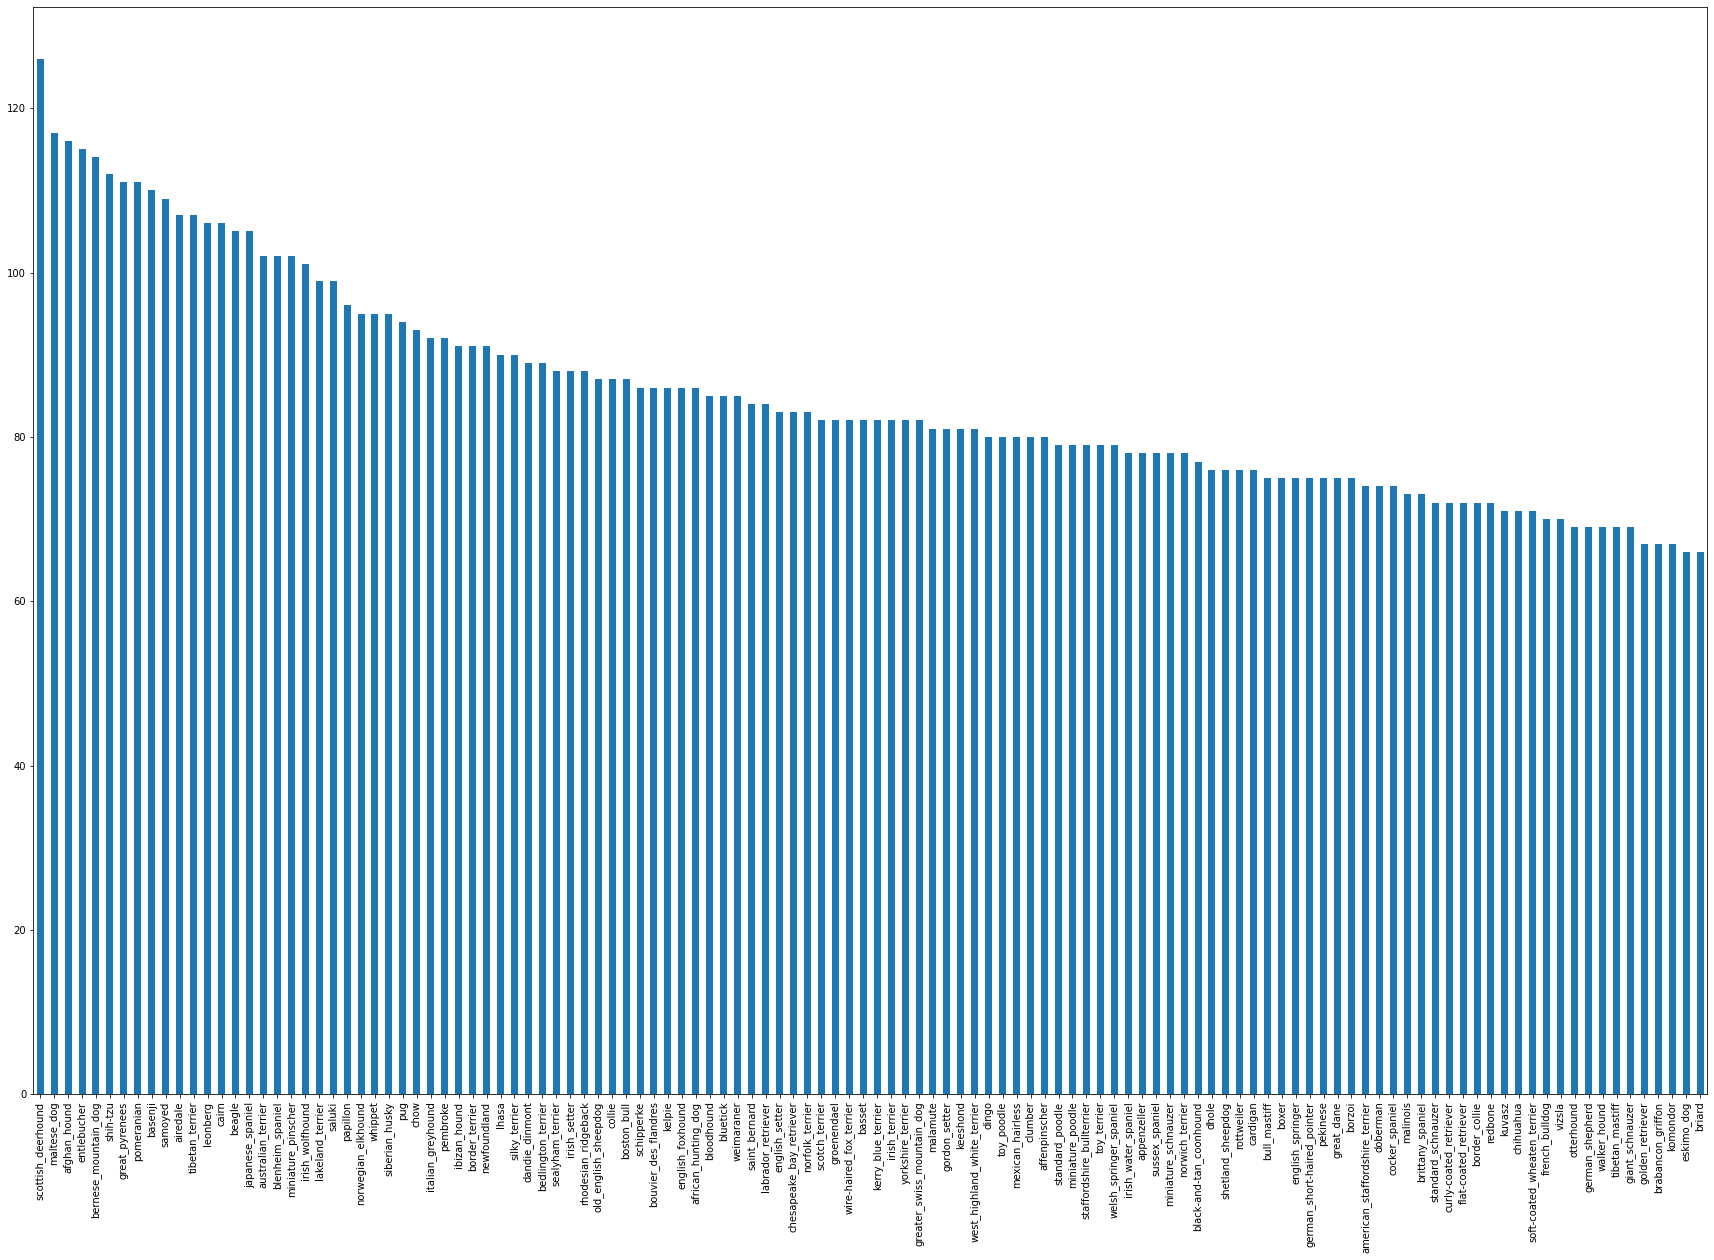

In [7]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(30, 20));

In [8]:
labels_csv['breed'].value_counts().median()

82.0

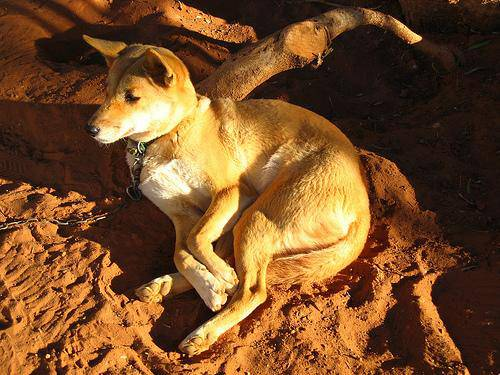

In [9]:
Image.open('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

In [18]:
# Check all unique breeds
labels = labels_csv['breed'].to_numpy()
filenames = [f'data/train/{fname}.jpg' for fname in labels_csv['id']]
unique_breeds = np.unique(labels)
filenames[:10], unique_breeds

(['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
  'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg'],
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'b

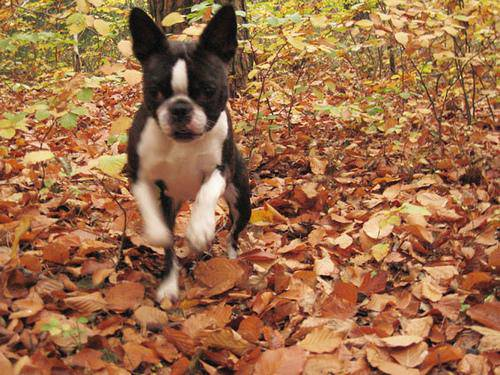

In [13]:
Image.open(filenames[0])

### Create Validation Set

Kaggle doesn't provide a validation set

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
# Use subset of samples for faster experimentation
NUM_IMAGES = 1000
X = filenames
y = boolean_labels

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocess Images (Convert unstructured data to Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1)
5. Resize the image to be a shape of (224, 224) and return it

In [28]:
test_image = plt.imread(filenames[0])

# 3-dimensional (RGB each from 0 to 255)
test_image.shape, test_image.max(), test_image.min()

((375, 500, 3), 255, 0)

In [29]:
# Image numPy array as a tensor
tf.constant(test_image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  7

In [34]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor of RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

### Create batches

Processing 10,000+ images in one go might not fit in memory; the preferred choice of batch size is usually 32

In order to use TensorFlow effectively, the data must be in the form of Tensor tuples which look like: (image, label).

In [35]:
# Create a function to return a Tensor tuple (image, label)
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

In [37]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    # test data doesn't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # No need to shuffle validation data: there's no use
    if valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices(
            (tf.constant(X), tf.constant(y))
        )
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices(
        (tf.constant(X), tf.constant(y))
    )

    # Shuffling (to prevent model learning on any orders/patterns) this
    # is faster than images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples & convert to batches
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [38]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


### Visualize batches

In [46]:
# Create a function for viewing images in a data batch
def show_n_images(images, labels, n=25):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        ax = plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1) 
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis('off')

In [40]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [49]:
# Shuffled - returns different images each time
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

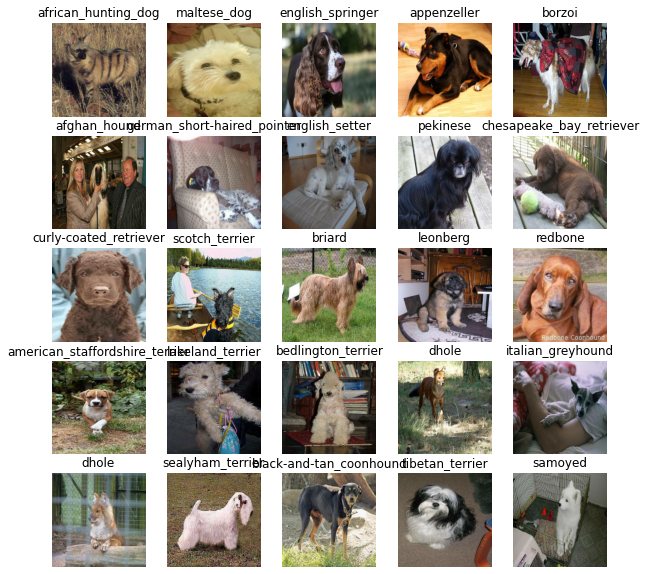

In [50]:
show_n_images(train_images, train_labels, 25)

In [53]:
val_images, val_labels = next(val_data.as_numpy_iterator())
len(val_images), len(val_labels)

(32, 32)

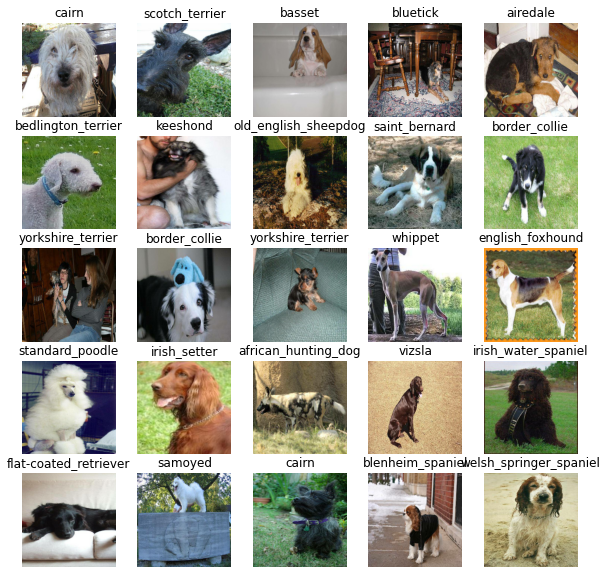

In [54]:
show_n_images(val_images, val_labels, 25)

# Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
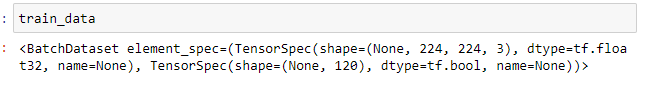

* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [56]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

### Create a model

let's create a function which:

* Takes the input shape, output shape and the model we've chosen.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Builds (tells the model the input shape it'll be getting) & returns the model .

https://www.tensorflow.org/guide/keras/overview

In [70]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        # Layer 1 (input layer)
        hub.KerasLayer(MODEL_URL),
        # Layer 2 (output layer)
        tf.keras.layers.Dense(
            units=OUTPUT_SHAPE,
            activation='linear'
        )
    ])

    # Compile the model
    model.compile(
      # Use CategoricalCrossEntropy since our labels are OHE
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [71]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Create callback functions

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks:
* TensorBoard
* Early Stopping

*Early Stopping*

Helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

*TensorBoard*

Helps track our models progress

In [66]:
%load_ext tensorboard
import datetime

# Build a TensorBoard callback
def create_tensorboard_callback():
    # Location to store TensorBoard logs
    logdir = os.path.join(
        'logs',
        # Track logs whenever we run an experiment (fit a model)
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return tf.keras.callbacks.TensorBoard(logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Train model on the subset (only 1000 images)

Let's create a function which:
* Creates a model
* Setup a TensorBoard callback
* Return the model fitted on the training data, validation data, number of epochs to train for and the callbacks we'd like to use

In [67]:
NUM_EPOCHS = 10

In [72]:
# Build a function to train and return a trained model
def train_model():
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data with the callbacks
    model.fit(
        x=train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard, early_stopping]
    )

    # Return the fitted model
    return model

In [73]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10
25/25 [==============================] - 45s 2s/step - loss: 4.7400 - accuracy: 0.1013 - val_loss: 3.6054 - val_accuracy: 0.2050
Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 1.6997 - accuracy: 0.6712 - val_loss: 2.2621 - val_accuracy: 0.4950
Epoch 3/10
25/25 [==============================] - 32s 1s/step - loss: 0.5925 - accuracy: 0.9400 - val_loss: 1.7329 - val_accuracy: 0.6050
Epoch 4/10
25/25 [==============================] - 33s 1s/step - loss: 0.2643 - accuracy: 0.9837 - val_loss: 1.5382 - val_accuracy: 0.6500
Epoch 5/10
25/25 [==============================] - 32s 1s/step - loss: 0.1525 - accuracy: 0.9962 - val_loss: 1.4417 - val_accuracy: 0.6550
Epoch 6/10
25/25 [==============================] - 33s 1s/step - loss: 0.1031 - accuracy: 1.0000 - val_loss: 1.3993 - val_accuracy: 0.6700
Epoch 7/10
25/25 [==============================] - 34s 1s/step - l

__Model seems to be overfitting__: performs better in training set but quite bad in validation set

In [74]:
# Visualize tensorboard logs
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19784), started 0:53:26 ago. (Use '!kill 19784' to kill it.)

# Creating Predictions

In [82]:
# Parse predictions into softmax function to convert them to probabilities
predictions = tf.nn.softmax(model.predict(val_data, verbose=1)).numpy()

7/7 [==============================] - 7s 847ms/step


In [87]:
# Predict single example
index = 42

print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

Max value (probability of prediction): 0.6247463226318359
Max index: 113
Predicted label: walker_hound


In [89]:
# Create a function to turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[index])
pred_label

'walker_hound'

In [90]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Since our valid data is still in a batch dataset, we'll have to unbatchify it to get the images - to make predictions on - & the true labels.

In [91]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278